In [3]:
import os
import math
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
UNK = 0
PAD = 1

from core.datasets.datasets import *
from core.datasets.sim import *           # inc_tmm 在这里
from core.models.transformer import *
from core.trains.train import *

# ================= 0) 光谱网格：380–750 nm，步长 5 nm =================
def make_wavelengths():
    return np.arange(380.0, 750.0 + 1e-9, 5.0)  # nm

# ================= 1) 折射率表 =================
lam_tab_tio2 = np.array([380.0,425.0,450.0,475.0,500.0,525.0,550.0,575.0,600.0,
                         625.0,650.0,675.0,750.0,775.0,800.0,825.0,850.0,900.0,
                         1000.0,1060.0])
n_tab_tio2   = np.array([2.55,2.49,2.469,2.444,2.422,2.402,2.385,2.37,2.351,
                         2.343,2.337,2.331,2.322,2.317,2.313,2.311,2.309,2.305,
                         2.300,2.299])
def n_tio2(lam_nm): return np.interp(lam_nm, lam_tab_tio2, n_tab_tio2)

lam_tab_sio2 = np.array([300.0,350.0,400.0,450.0,500.0,550.0,600.0,650.0,700.0,900.0,1000.0])
n_tab_sio2   = np.array([1.478 ,1.472 ,1.467 ,1.463 ,1.459 ,1.455 ,1.452 ,1.450 ,1.446 ,1.437 ,1.434])
def n_sio2(lam_nm): return np.interp(lam_nm, lam_tab_sio2, n_tab_sio2)

lam_tab_mgf2 = np.array([248.0, 550.0, 1550.0])
n_tab_mgf2   = np.array([1.40 , 1.38 , 1.36  ])
def n_mgf2(lam_nm): return np.interp(lam_nm, lam_tab_mgf2, n_tab_mgf2)

glass_n_const = 1.5163
def n_glass(lam_nm): return np.full_like(lam_nm, glass_n_const, dtype=float)

# ================= 2) 网格与 nk_dict =================
lam_nm = make_wavelengths()                # nm
wavelengths = lam_nm / 1e3                 # µm
nk_dict = {
    'TiO2': n_tio2(lam_nm).astype(np.complex128),
    'SiO2': n_sio2(lam_nm).astype(np.complex128),
    'MgF2': n_mgf2(lam_nm).astype(np.complex128),
    'Glass_Substrate': n_glass(lam_nm).astype(np.complex128),
}

# ================= 3) TMM 包装：返回 [R..., T...] =================
def spectrum(materials, thickness, pol='s', theta=0, wavelengths=None,
             nk_dict=None, substrate='Glass_Substrate', substrate_thick=500000):
    assert len(materials) == len(thickness)
    assert nk_dict is not None and wavelengths is not None
    assert pol in ('s','p','u')

    theta_rad = theta * (math.pi / 180.0)
    wavess = (1e3 * np.asarray(wavelengths)).astype(int)

    thickness_full = [np.inf] + list(thickness) + [substrate_thick, np.inf]
    inc_list = ['i'] + ['c'] * len(materials) + ['i', 'i']

    R, T = [], []
    def _rt(pol_char, n_list, d_list, inc_list, theta_in, lambda_vac):
        res = inc_tmm(pol_char, n_list, d_list, inc_list, theta_in, lambda_vac)
        return res['R'], res['T']

    for i, lambda_vac in enumerate(wavess):
        n_list = [1.0] + [nk_dict[m][i] for m in materials] + [nk_dict[substrate][i], 1.0]
        if pol == 'u':
            rs, ts = _rt('s', n_list, thickness_full, inc_list, theta_rad, lambda_vac)
            rp, tp = _rt('p', n_list, thickness_full, inc_list, theta_rad, lambda_vac)
            r, t = 0.5*(rs+rp), 0.5*(ts+tp)
        else:
            r, t = _rt(pol, n_list, thickness_full, inc_list, theta_rad, lambda_vac)
        R.append(float(r)); T.append(float(t))
    return R + T

# ================= 5) 加载模型（只做推理） =================
a = torch.load('/data/PXY/optogpt/optogpt/saved_models/optogpt/test/model_inverse_R_T_S_R_B_LR_WU_L_H_D_F_[2, 0.05, 1024, 0.0004, 2000, 6, 8, 512, 2048]_best04.pt', map_location=DEVICE)
args = a['configs']
torch.manual_seed(args.seeds); np.random.seed(args.seeds)

model = make_model_I(args.spec_dim, args.struc_dim, args.layers, args.d_model, args.d_ff, args.head_num, args.dropout).to(DEVICE)
model.load_state_dict(a['model_state_dict'])
criterion = LabelSmoothing(args.struc_dim, padding_idx=0, smoothing=args.smoothing)
count_params(model)

# 仅为拿词典与分批工具：不必真的加载/覆盖训练数据
TRAIN_FILE = './dataset/Structure_train.pkl'
TRAIN_SPEC_FILE = './dataset/Spectrum_train.pkl'
DEV_FILE = './dataset/Structure_dev.pkl'
DEV_SPEC_FILE = './dataset/Spectrum_dev.pkl'
data = PrepareData(TRAIN_FILE, TRAIN_SPEC_FILE, args.ratios, DEV_FILE, DEV_SPEC_FILE, args.batch_size, 'R_T', 'Inverse')
data.struc_word_dict, data.struc_index_dict = a['configs'].struc_word_dict, a['configs'].struc_index_dict

# ================= 6) 工具函数：解析/评估 =================
SPECIAL = {"BOS","EOS","PAD","UNK", None, ""}

def clean_tokens(tokens):
    out = []
    for tok in tokens:
        if tok in SPECIAL:
            if tok == "EOS": break
            continue
        out.append(tok)
    return out


def return_mat_thick(tokens, max_layers=20):
    tokens = clean_tokens(tokens)[:max_layers]
    mats, thks = [], []
    for tok in tokens:
        s = str(tok)
        if "_" not in s:
            if mats and s.replace(".","",1).isdigit():
                mats.append(mats[-1]); thks.append(float(s))
            continue
        mat, thk = s.split("_", 1)
        num = "".join(ch for ch in thk if ch.isdigit() or ch==".")
        if not num: continue
        thks.append(float(num)); mats.append(mat)
    return mats, thks


def _is_vector(x, n=None):
    try: arr = np.asarray(x).squeeze()
    except Exception: return False
    if arr.ndim != 1: return False
    return (n is None) or (arr.size == n)


def extract_RT(spec_obj, wavelengths_len: int):
    if isinstance(spec_obj, (list, tuple)):
        if len(spec_obj) >= 2 and all(_is_vector(v) for v in spec_obj[:2]):
            return np.asarray(spec_obj[0]).squeeze(), np.asarray(spec_obj[1]).squeeze()
    if isinstance(spec_obj, dict):
        keys = {str(k).lower(): k for k in spec_obj.keys()}
        if "r" in keys and "t" in keys:
            return np.asarray(spec_obj[keys["r"]]).squeeze(), np.asarray(spec_obj[keys["t"]]).squeeze()
        r_key = next((k for k in spec_obj if str(k).lower().startswith("r")), None)
        t_key = next((k for k in spec_obj if str(k).lower().startswith("t")), None)
        if r_key is not None and t_key is not None:
            return np.asarray(spec_obj[r_key]).squeeze(), np.asarray(spec_obj[t_key]).squeeze()
    for attr_r in ("R","r"):
        for attr_t in ("T","t"):
            if hasattr(spec_obj, attr_r) and hasattr(spec_obj, attr_t):
                return np.asarray(getattr(spec_obj, attr_r)).squeeze(), np.asarray(getattr(spec_obj, attr_t)).squeeze()
    arr = np.asarray(spec_obj).squeeze()
    wl = wavelengths_len
    if arr.ndim == 1 and arr.size == 2 * wl:
        first, second = arr[:wl], arr[wl:]
        if np.all((first>=0)&(first<=1)) and np.all((second>=0)&(second<=1)):
            return first, second
        return second, first
    raise ValueError("extract_RT: 无法解析 (R,T)。")


def assemble_spec_vector(R, T):
    R = np.asarray(R, dtype=np.float32).reshape(-1)
    T = np.asarray(T, dtype=np.float32).reshape(-1)
    assert R.shape == T.shape, f"R/T 长度不一致: {R.shape} vs {T.shape}"
    return np.concatenate([R, T], axis=0)


def weighted_mae(y_true, y_pred, w=None):
    a = np.asarray(y_true, dtype=np.float64)
    b = np.asarray(y_pred, dtype=np.float64)
    if w is None: return float(np.mean(np.abs(a-b)))
    w = np.asarray(w, dtype=np.float64)
    return float(np.sum(np.abs(a-b)*w) / (np.sum(w)+1e-12))


def parse_user_targets(directives_text: str, wavelengths_nm, 
                       default_R: float = 0.0, default_T: float = 0.0,
                       clip01: bool = True):
    wl = np.asarray(wavelengths_nm, dtype=float).reshape(-1)
    N = wl.size
    pts = {"R": [], "T": []}
    lines = [ln.strip() for ln in str(directives_text).strip().splitlines() if ln.strip()]
    for raw in lines:
        parts = [p.strip() for p in raw.split(',')]
        if len(parts) < 3:
            raise ValueError(f"格式错误: {raw}，应为 通道, 波长, 值[, 权重]")
        ch = parts[0].upper()
        if ch not in ("R", "T"):
            raise ValueError(f"未知通道: {ch}（只支持 R/T）")
        lam = float(parts[1])
        val = float(parts[2])
        if val > 1.0: 
            val = val / 100.0
        pts[ch].append((lam, val))

    def build_channel(target_points, default_val):
        if len(target_points) == 0:
            arr = np.full(N, float(default_val), dtype=np.float32)
        elif len(target_points) == 1:
            v = float(target_points[0][1])
            arr = np.full(N, v, dtype=np.float32)
        else:
            target_points = sorted(target_points, key=lambda x: x[0])
            xs = np.array([p[0] for p in target_points], dtype=float)
            ys = np.array([p[1] for p in target_points], dtype=float)
            arr = np.interp(wl, xs, ys, left=ys[0], right=ys[-1]).astype(np.float32)
        if clip01:
            np.clip(arr, 0.0, 1.0, out=arr)
        return arr

    R = build_channel(pts["R"], default_R)
    T = build_channel(pts["T"], default_T)
    return R, T


def build_spec_weights_from_points(wavelengths_nm, directives_text, base=1.0):
    """
    重要说明：默认 base=1.0  —— 未指定的点默认权重=1。
    如需“仅锚点计分”，把 base 传 0.0。
    """
    wl = np.asarray(wavelengths_nm, dtype=float).reshape(-1)
    N = wl.size
    wR = np.full(N, base, dtype=np.float32)
    wT = np.full(N, base, dtype=np.float32)
    lines = [ln.strip() for ln in directives_text.strip().splitlines() if ln.strip()]
    for raw in lines:
        parts = [p.strip() for p in raw.split(',')]
        if len(parts) < 4:
            raise ValueError(f"格式错误: {raw}，应为 通道, 波长, 值, 权重")
        ch, lam, _val, alpha = parts[0].upper(), float(parts[1]), float(parts[2]), float(parts[3])
        idx = int(np.argmin(np.abs(wl - lam)))
        if ch == "R": wR[idx] = float(alpha)
        elif ch == "T": wT[idx] = float(alpha)
        else: raise ValueError(f"未知通道 {ch}")
    return np.concatenate([wR, wT], axis=0)

# （可选）高斯带宽权重
def build_spec_weights_from_points_gaussian(wavelengths_nm, directives_text, sigma_nm=15.0, base=0.0):
    wl = np.asarray(wavelengths_nm, dtype=float).reshape(-1)
    N = wl.size
    wR = np.full(N, base, dtype=np.float32)
    wT = np.full(N, base, dtype=np.float32)
    lines = [ln.strip() for ln in directives_text.strip().splitlines() if ln.strip()]
    for raw in lines:
        parts = [p.strip() for p in raw.split(',')]
        if len(parts) < 4:
            raise ValueError(f"格式错误: {raw}")
        ch, lam, _val, alpha = parts[0].upper(), float(parts[1]), float(parts[2]), float(parts[3])
        g = np.exp(-0.5 * ((wl - lam)/sigma_nm)**2)
        g = g / (g.max() + 1e-12) * float(alpha)
        if ch == "R": wR = np.maximum(wR, g.astype(np.float32))
        elif ch == "T": wT = np.maximum(wT, g.astype(np.float32))
        else: raise ValueError(f"未知通道 {ch}")
    return np.concatenate([wR, wT], axis=0)

# ================= 7) 解码辅助：约束与抽样 =================

def mask_invalid_next(probs, word_dict, step_layers, max_layers=20):
    if probs.dim() == 2: probs = probs[0]
    probs = probs.clone()
    eos_id = word_dict['EOS']
    bos_id = word_dict['BOS']
    if step_layers >= max_layers:
        keep = torch.zeros_like(probs); keep[eos_id] = 1.0
        probs = probs * keep
    else:
        probs[bos_id] = 0.0
    s = probs.sum()
    if s.item() <= 0:
        probs[:] = 0.0
        probs[eos_id] = 1.0
    else:
        probs = probs / s
    return probs.unsqueeze(0)


def apply_top_k_top_p(logits, top_k=10, top_p=0.8):
    top_k = max(1, int(top_k))
    sorted_logits, sorted_idx = torch.sort(logits, dim=-1, descending=True)
    if top_k < logits.size(-1):
        thresh = sorted_logits[..., top_k-1:top_k]
        remove = sorted_logits < thresh
        sorted_logits = sorted_logits.masked_fill(remove, float('-inf'))
    probs_sorted = torch.softmax(sorted_logits, dim=-1)
    cum = probs_sorted.cumsum(dim=-1)
    remove = cum > top_p
    remove[..., 0] = False
    sorted_logits = sorted_logits.masked_fill(remove, float('-inf'))
    out = torch.full_like(logits, float('-inf'))
    out.scatter_(1, sorted_idx, sorted_logits)
    return out

# ================= 8) 解码器：≤20 层 + EOS =================

def greedy_decode_w(model, struc_word_dict, R_target, T_target, max_len,
                    start_symbol="BOS", spec_weights=None, device=None,
                    eos_bias_after=15, eos_bias_logit=1.5, max_layers=20):
    DEVICE = device or next(model.parameters()).device
    id2tok = {v: k for k, v in struc_word_dict.items()}
    BOS_id = struc_word_dict.get(start_symbol, 2)
    EOS_id = struc_word_dict['EOS']
    PAD_id = 0
    spec_vec = assemble_spec_vector(R_target, T_target)
    src = torch.tensor([spec_vec], dtype=torch.float32, device=DEVICE)
    ys = torch.tensor([[BOS_id]], dtype=torch.long, device=DEVICE)
    step_layers = 0
    probs_hist = []
    for _ in range(max_len - ys.size(1)):
        tgt_mask = (ys != PAD_id).unsqueeze(-2) & (subsequent_mask(ys.size(-1)).to(ys.device))
        out = model(src, ys, src_mask=None, tgt_mask=tgt_mask)
        dec_last = out[:, -1, :]
        logp = model.generator(dec_last)
        if step_layers >= eos_bias_after:
            logp[:, EOS_id] = logp[:, EOS_id] + eos_bias_logit
        probs = torch.exp(logp)
        probs = mask_invalid_next(probs, struc_word_dict, step_layers, max_layers=max_layers)
        next_id = int(torch.argmax(probs, dim=-1).item())
        probs_hist.append(float(probs[0, next_id].item()))
        ys = torch.cat([ys, torch.tensor([[next_id]], dtype=torch.long, device=DEVICE)], dim=1)
        if next_id == EOS_id: break
        step_layers += 1
    if step_layers >= max_layers and ys[0, -1].item() != EOS_id:
        ys = torch.cat([ys, torch.tensor([[EOS_id]], dtype=torch.long, device=DEVICE)], dim=1)
    raw_tokens = [id2tok.get(tid, None) for tid in ys[0].tolist()]
    cleaned_tokens = []
    for tok in raw_tokens:
        if tok in {"BOS","PAD","UNK", None, ""}: continue
        if tok == "EOS": break
        cleaned_tokens.append(tok)
    return raw_tokens, cleaned_tokens, probs_hist


def top_k_n_w(k, top_p, model, struc_word_dict, R_target, T_target, max_len,
              start_symbol="BOS", spec_weights=None, device=None,
              temperature=1.0, start_mat=None, eos_bias_after=15,
              eos_bias_logit=1.5, max_layers=20):
    DEVICE = device or next(model.parameters()).device
    id2tok = {v: k for k, v in struc_word_dict.items()}
    BOS_id  = struc_word_dict.get(start_symbol, 2)
    EOS_id  = struc_word_dict['EOS']
    PAD_id  = 0
    spec_vec = assemble_spec_vector(R_target, T_target)
    src = torch.tensor([spec_vec], dtype=torch.float32, device=DEVICE)
    if start_mat:
        ys = torch.tensor([[BOS_id, struc_word_dict[start_mat]]], dtype=torch.long, device=DEVICE)
        step_layers = 1
    else:
        ys = torch.tensor([[BOS_id]], dtype=torch.long, device=DEVICE)
        step_layers = 0
    probs_hist = []
    for _ in range(max_len - ys.size(1)):
        tgt_mask = (ys != PAD_id).unsqueeze(-2) & (subsequent_mask(ys.size(-1)).to(ys.device))
        out = model(src, ys, src_mask=None, tgt_mask=tgt_mask)
        dec_last = out[:, -1, :]
        logp = model.generator(dec_last) / max(1e-6, float(temperature))
        if step_layers >= eos_bias_after:
            logp[:, EOS_id] = logp[:, EOS_id] + eos_bias_logit
        logits_kept = apply_top_k_top_p(logp, top_k=k, top_p=top_p)
        probs = torch.softmax(logits_kept, dim=-1)
        probs = mask_invalid_next(probs, struc_word_dict, step_layers, max_layers=max_layers)
        next_id = int(torch.multinomial(probs, num_samples=1).item())
        probs_hist.append(float(probs[0, next_id].item()))
        ys = torch.cat([ys, torch.tensor([[next_id]], dtype=torch.long, device=DEVICE)], dim=1)
        if next_id == EOS_id: break
        step_layers += 1
    if step_layers >= max_layers and ys[0, -1].item() != EOS_id:
        ys = torch.cat([ys, torch.tensor([[EOS_id]], dtype=torch.long, device=DEVICE)], dim=1)
    tokens = []
    for tid in ys[0].tolist():
        tok = id2tok.get(tid, None)
        if tok in (None, 'BOS', 'PAD', 'UNK'): continue
        if tok == 'EOS': break
        tokens.append(tok)
    return tokens, probs_hist

# ================= 9) 用户点 → 目标/权重 =================
user_directives_text = """
R,385,0.42,2
T,550,0.80,4
R,700,0.30,3
""".strip()

R_target, T_target = parse_user_targets(user_directives_text, lam_nm)

# —— 权重策略：二选一 ——
USE_FULLBAND_WEIGHT = True  # True: 全谱默认=1；False: 仅锚点

if USE_FULLBAND_WEIGHT:
    spec_weights = build_spec_weights_from_points(lam_nm, user_directives_text, base=1.0)
else:
    spec_weights = build_spec_weights_from_points(lam_nm, user_directives_text, base=0.0)
# 也可使用高斯带宽版本：
# spec_weights = build_spec_weights_from_points_gaussian(lam_nm, user_directives_text, sigma_nm=15.0, base=0.0)

N = len(lam_nm)
assert len(R_target) == N and len(T_target) == N
spec_target_vec = assemble_spec_vector(R_target, T_target)

# ================= 10) TFCalc 评分（独立函数 + 参数构造，含“权重→Tol”） =================

def tfcalc_merit(
    C_vec, T_vec,
    N_vec=None, Tol_vec=None,
    I=1.0, D=1.0,
    k=2, eps=1e-12
):
    C = np.asarray(C_vec, dtype=np.float64).reshape(-1)
    T = np.asarray(T_vec, dtype=np.float64).reshape(-1)
    assert C.shape == T.shape, "C/T 维度不一致"
    m = C.size
    def _to_arr(x):
        if x is None: return np.ones_like(C, dtype=np.float64)
        x = np.asarray(x, dtype=np.float64)
        return x if x.shape == C.shape else np.full_like(C, float(x), dtype=np.float64)
    N   = _to_arr(N_vec)
    Tol = _to_arr(Tol_vec)
    Iv  = _to_arr(I)
    Dv  = _to_arr(D)
    diff_k = np.power(np.abs(C - T) + eps, float(k))
    term   = (Iv * Dv * diff_k) / (np.maximum(N * Tol, eps))
    F_powk = np.sum(term) / max(1, m)
    F      = np.power(F_powk, 1.0/float(k))
    return float(F)


def build_tfcalc_params(
    wavelengths_nm,
    directives_text=None,
    N=1.0,
    Tol=0.05,
    I=1.0,
    D=1.0,
    use_weight_to_tol=True,   # ✅ 新增：是否把第4列权重映射到 Tol
):
    """
    构造与 [R...,T...] 对齐的 N/Tol/I/D 向量。
    如果 use_weight_to_tol=True，则： Tol_effective = Tol / alpha
    （alpha 为 user_directives_text 第4列权重；alpha 大 → Tol 小 → 更严格）
    未指定的波长点使用常量 N、Tol、I、D。
    """
    wl = np.asarray(wavelengths_nm, dtype=float).reshape(-1)
    Nw   = np.full(wl.size, float(N), dtype=np.float32)
    Tolw = np.full(wl.size, float(Tol), dtype=np.float32)
    Iw   = np.full(wl.size, float(I), dtype=np.float32)
    Dw   = np.full(wl.size, float(D), dtype=np.float32)

    if directives_text:
        lines = [ln.strip() for ln in directives_text.strip().splitlines() if ln.strip()]
        for raw in lines:
            parts = [p.strip() for p in raw.split(",")]
            if len(parts) < 2:
                continue
            ch, lam = parts[0].upper(), float(parts[1])
            alpha = float(parts[3]) if len(parts) >= 4 else 1.0
            idx = int(np.argmin(np.abs(wl - lam)))
            # N 保持常量；Tol 根据权重调整
            if use_weight_to_tol:
                Tolw[idx] = float(Tol) / max(alpha, 1e-6)
            else:
                Tolw[idx] = float(Tol)
            # I/D 在此按常量设置；如需按通道/波长自定义，可在此改为函数
            Iw[idx] = float(I)
            Dw[idx] = float(D)

    return (
        np.concatenate([Nw,   Nw  ], axis=0),
        np.concatenate([Tolw, Tolw], axis=0),
        np.concatenate([Iw,   Iw  ], axis=0),
        np.concatenate([Dw,   Dw  ], axis=0),
    )

# —— 用权重驱动 Tol（推荐） ——
N_vec, Tol_vec, I_vec, D_vec = build_tfcalc_params(
    lam_nm,
    directives_text=user_directives_text,
    N=1.0, Tol=0.05, I=1.0, D=1.0,
    use_weight_to_tol=True
)
TF_K = 2  # 1/2/4/8/16… 越大对大偏差越敏感

# ================= 11) 评估 & 搜索 =================

def eval_structure(tokens_list):
    if not tokens_list:
        zR, zT = np.zeros_like(R_target), np.zeros_like(T_target)
        return float("inf"), float("inf"), float("inf"), (zR, zT)
    try:
        mats, thks = return_mat_thick(tokens_list)
        spec_obj = spectrum(
            mats, thks, wavelengths=wavelengths, nk_dict=nk_dict,
            substrate='Glass_Substrate', substrate_thick=500000
        )
        R_sim, T_sim = extract_RT(spec_obj, wavelengths_len=len(wavelengths))
        vec_sim = assemble_spec_vector(R_sim, T_sim)

        mae_plain  = float(np.mean(np.abs(vec_sim - spec_target_vec)))
        mae_weight = weighted_mae(spec_target_vec, vec_sim, w=spec_weights)

        tf_merit = tfcalc_merit(
            C_vec=vec_sim, T_vec=spec_target_vec,
            N_vec=N_vec, Tol_vec=Tol_vec, I=I_vec, D=D_vec, k=TF_K
        )
        return mae_plain, mae_weight, tf_merit, (R_sim, T_sim)
    except Exception as e:
        print("[WARN] eval_structure failed:", e)
        zR, zT = np.zeros_like(R_target), np.zeros_like(T_target)
        return float("inf"), float("inf"), float("inf"), (zR, zT)

# # 带MAE的
# model.eval()
# with torch.no_grad():
#     # ---- 贪心 ----
#     raw_tokens, cleaned_tokens, probs_g = greedy_decode_w(
#         model, data.struc_word_dict, R_target, T_target,
#         max_len=getattr(args, "max_len", 22),
#         start_symbol="BOS",
#         spec_weights=None,
#         device=DEVICE
#     )
#     print("[Greedy] raw tokens:  ", raw_tokens)
#     print("[Greedy] clean tokens:", cleaned_tokens)

#     mae_plain, mae_weight, tf_merit, (R_g, T_g) = eval_structure(cleaned_tokens)
#     print("[Greedy] MAE=%.6f | wMAE=%.6f | TF=%.6f" % (mae_plain, mae_weight, tf_merit), cleaned_tokens)

#     # 以 TFCalc 为主（异常则回退 wMAE）
#     best_score  = tf_merit if np.isfinite(tf_merit) else mae_weight
#     best_struct = cleaned_tokens
#     best_spec   = (R_g, T_g)
#     best_tag    = "Greedy"

#     # ---- 采样若干解：用 TFCalc 选最优 ----
#     print("Top-kp sampling:")
#     SAMPLES = 20
#     for kk in range(SAMPLES):
#         struc_k, probs_k = top_k_n_w(
#             k=10, top_p=0.8,
#             model=model, struc_word_dict=data.struc_word_dict,
#             R_target=R_target, T_target=T_target,
#             max_len=getattr(args, "max_len", 22),
#             start_symbol="BOS",
#             spec_weights=None,
#             device=DEVICE
#         )
#         mae_p, mae_w, tf_m, (R_k, T_k) = eval_structure(struc_k)
#         use_score = tf_m if np.isfinite(tf_m) else mae_w
#         print(f"  Structure {kk:02d}: TF= {tf_m:.6f} | wMAE= {mae_w:.6f}", struc_k)

#         if use_score < best_score:
#             best_score  = use_score
#             best_struct = struc_k
#             best_spec   = (R_k, T_k)
#             best_tag    = f"Sample#{kk:02d}"

# print("\n=== Best by TFCalc (fallback wMAE) ===")
# print("source:", best_tag)
# print("score:", best_score)
# print("structure:", best_struct)


In [4]:
model.eval()
with torch.no_grad():
    # ---- 贪心 ----
    raw_tokens, cleaned_tokens, probs_g = greedy_decode_w(
        model, data.struc_word_dict, R_target, T_target,
        max_len=getattr(args, "max_len", 22),
        start_symbol="BOS",
        spec_weights=None,
        device=DEVICE
    )
    print("[Greedy] raw tokens:  ", raw_tokens)
    print("[Greedy] clean tokens:", cleaned_tokens)

    mae_plain, mae_weight, tf_merit, (R_g, T_g) = eval_structure(cleaned_tokens)
    # ✅ 只显示 TFCalc 分数
    print(f"[Greedy] TF= {tf_merit:.6f}", cleaned_tokens)

    # 以 TFCalc 为主（异常则回退 wMAE）
    best_score  = tf_merit if np.isfinite(tf_merit) else mae_weight
    best_struct = cleaned_tokens
    best_spec   = (R_g, T_g)
    best_tag    = "Greedy"

    # ---- 采样若干解：用 TFCalc 选最优 ----
    print("Top-kp sampling:")
    SAMPLES = 20
    for kk in range(SAMPLES):
        struc_k, probs_k = top_k_n_w(
            k=10, top_p=0.8,
            model=model, struc_word_dict=data.struc_word_dict,
            R_target=R_target, T_target=T_target,
            max_len=getattr(args, "max_len", 22),
            start_symbol="BOS",
            spec_weights=None,
            device=DEVICE
        )
        mae_p, mae_w, tf_m, (R_k, T_k) = eval_structure(struc_k)
        # ✅ 同样只显示 TF 分数
        print(f"  Structure {kk:02d}: TF= {tf_m:.6f}", struc_k)

        use_score = tf_m if np.isfinite(tf_m) else mae_w
        if use_score < best_score:
            best_score  = use_score
            best_struct = struc_k
            best_spec   = (R_k, T_k)
            best_tag    = f"Sample#{kk:02d}"

print("\n=== Best by TFCalc===")
print("source:", best_tag)
print("score:", best_score)
print("structure:", best_struct)


/tmp/ipykernel_1562278/1207740288.py:303: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343998658/work/torch/csrc/utils/tensor_new.cpp:245.)
  src = torch.tensor([spec_vec], dtype=torch.float32, device=DEVICE)


[Greedy] raw tokens:   ['BOS', 'TiO2_20', 'EOS']
[Greedy] clean tokens: ['TiO2_20']
[Greedy] TF= 0.583518 ['TiO2_20']
Top-kp sampling:
  Structure 00: TF= 0.825653 ['TiO2_20', 'SiO2_100', 'TiO2_100', 'TiO2_300', 'TiO2_260', 'MgF2_210']
  Structure 01: TF= 0.995142 ['SiO2_130', 'MgF2_130', 'SiO2_220']
  Structure 02: TF= 1.087361 ['MgF2_90']
  Structure 03: TF= 0.834997 ['SiO2_30', 'SiO2_220', 'MgF2_110', 'TiO2_170', 'MgF2_230', 'SiO2_210']
  Structure 04: TF= 1.006210 ['SiO2_30', 'SiO2_80', 'SiO2_120']
  Structure 05: TF= inf []
  Structure 06: TF= 0.674567 ['MgF2_90', 'SiO2_120', 'TiO2_200']
  Structure 07: TF= inf []
  Structure 08: TF= 0.725522 ['SiO2_30', 'SiO2_80', 'MgF2_260', 'MgF2_80', 'MgF2_170', 'MgF2_170', 'TiO2_170']
  Structure 09: TF= 1.023943 ['SiO2_130', 'SiO2_50', 'SiO2_30', 'MgF2_260', 'MgF2_160']
  Structure 10: TF= 0.653908 ['SiO2_40', 'TiO2_150', 'TiO2_20']
  Structure 11: TF= 0.583518 ['TiO2_20']
  Structure 12: TF= 0.628367 ['TiO2_20', 'TiO2_260', 'TiO2_120', 'SiO

Final dev loss: 3.644822597503662


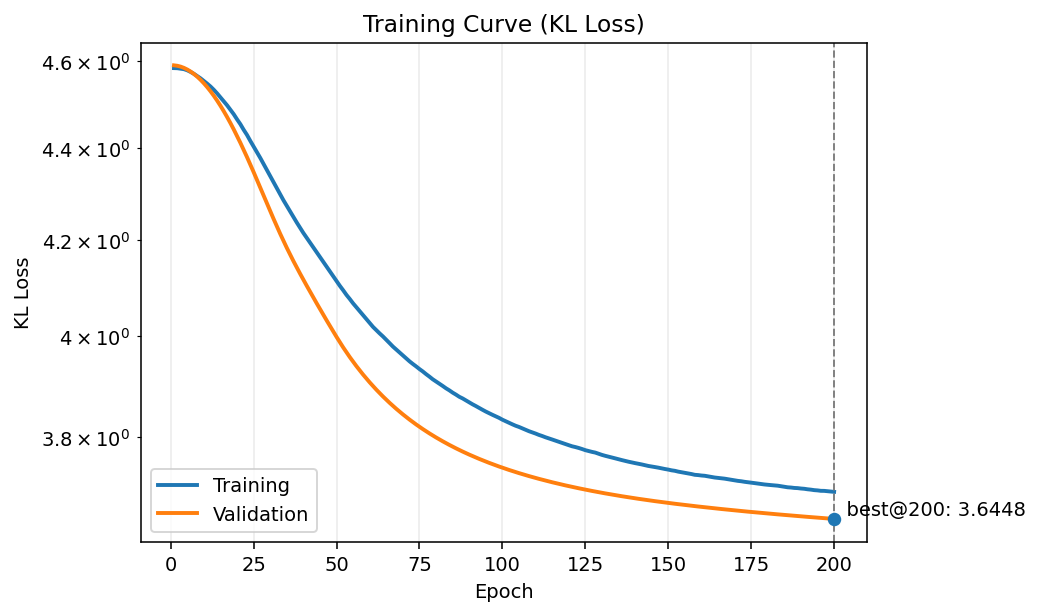

[saved] ./training_curve_kl.png


In [8]:
# ================= 绘图：训练/验证曲线（可单独运行，自动加载 ckpt） =================
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from typing import Sequence, Any

# —— 需要重新加载一次模型/日志（独立运行时使用） ——
CKPT_PATH = "/data/PXY/optogpt/optogpt/saved_models/optogpt/test/model_inverse_R_T_S_R_B_LR_WU_L_H_D_F_[2, 0.05, 1024, 0.0004, 2000, 6, 8, 512, 2048]_best07.pt"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
assert os.path.exists(CKPT_PATH), f"checkpoint not found: {CKPT_PATH}"
ckpt = torch.load(CKPT_PATH, map_location=DEVICE)
loss_all = ckpt.get("loss_all", {})


def _to_1d_list(x: Any):
    """
    把 list/tuple/np.ndarray/torch.Tensor → 纯 Python list[float]
    自动 .cpu().item()，自动展平。
    """
    if x is None:
        return None
    if isinstance(x, torch.Tensor):
        if x.ndim == 0:
            return [float(x.detach().cpu().item())]
        return [float(t.detach().cpu().item()) for t in x.reshape(-1)]
    if isinstance(x, np.ndarray):
        return [float(v) for v in x.reshape(-1)]
    if isinstance(x, (list, tuple)):
        out = []
        for v in x:
            if isinstance(v, torch.Tensor):
                out.append(float(v.detach().cpu().item()))
            elif isinstance(v, (np.ndarray, list, tuple)):
                out.extend(_to_1d_list(v))
            else:
                out.append(float(v))
        return out
    # 单个标量
    try:
        return [float(x)]
    except Exception:
        return None


def _moving_average(y: Sequence[float], k: int):
    if y is None or len(y) == 0 or k <= 1:
        return y
    k = min(k, len(y))
    pad = k // 2
    y_pad = np.pad(np.asarray(y, dtype=float), (pad, pad), mode='edge')
    kernel = np.ones(k, dtype=float) / k
    return np.convolve(y_pad, kernel, mode='valid').tolist()


def plot_train_curves(loss_train, loss_eval, *,
                      title="Training Curve",
                      ylabel="Loss",
                      smooth=0,         # 平滑窗口（奇数，0/1 表示不平滑）
                      logy=True,        # y 轴取对数
                      savepath="./training_curve.png"):
    lt = _to_1d_list(loss_train) or []
    lv = _to_1d_list(loss_eval)  or []
    # 截齐长度（有些日志 eval 少于 train）
    n = min(len(lt), len(lv)) if lv else len(lt)
    x = list(range(1, n + 1))
    lt = lt[:n]
    if lv: lv = lv[:n]

    lt_plot = _moving_average(lt, smooth) if smooth and smooth > 1 else lt
    lv_plot = _moving_average(lv, smooth) if lv and smooth and smooth > 1 else lv

    plt.figure(figsize=(7.5, 4.5), dpi=140)
    plt.plot(x, lt_plot, label="Training", linewidth=2)
    if lv_plot:
        plt.plot(x, lv_plot, label="Validation", linewidth=2)

        # 标注最佳 epoch（取验证集最小值）
        best_idx = int(np.argmin(lv))  # 原始未平滑上的最佳
        best_x = best_idx + 1
        best_y = lv[best_idx]
        plt.axvline(best_x, color='gray', linestyle='--', linewidth=1)
        plt.scatter([best_x], [best_y], s=35, zorder=5)
        plt.text(best_x, best_y, f"  best@{best_x}: {best_y:.4f}", va='bottom', fontsize=10)

    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    if logy:
        plt.yscale("log")
    plt.grid(True, alpha=0.25)
    plt.legend()
    plt.tight_layout()
    plt.savefig(savepath)
    plt.show()
    print(f"[saved] {savepath}")


# ====== 从 checkpoint 里取出曲线并绘图 ======
# 兼容你之前的结构：loss_all['train_loss'] / ['dev_loss']
train_curve = loss_all.get("train_loss", None)
dev_curve   = loss_all.get("dev_loss",   None)

print("Final dev loss:", (_to_1d_list(dev_curve) or [None])[-1])

# 主图：KL loss 曲线（对数坐标，平滑窗口=3 可改 0/1 表示不平滑）
plot_train_curves(train_curve, dev_curve,
                  title="Training Curve (KL Loss)",
                  ylabel="KL Loss",
                  smooth=3,
                  logy=True,
                  savepath="./training_curve_kl.png")

# 若 ckpt 里还有其它可选曲线（可选：学习率、准确率等），也尝试绘图
lrs = loss_all.get("lrs", None)
if lrs is not None:
    plot_train_curves(lrs, None,
                      title="Learning Rate (per epoch)",
                      ylabel="LR",
                      smooth=1,
                      logy=False,
                      savepath="./training_curve_lr.png")

train_acc = loss_all.get("train_acc", None)
dev_acc   = loss_all.get("dev_acc", None)
if train_acc is not None or dev_acc is not None:
    plot_train_curves(train_acc, dev_acc,
                      title="Accuracy Curve",
                      ylabel="Accuracy",
                      smooth=3,
                      logy=False,
                      savepath="./training_curve_acc.png")